## Part 2 of: "learning the Q-values with a neural network" ##

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In [21]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


In [22]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [23]:
class DataSet():
    def __init__(self, rpbgo=10, nbetas=10):
        #rpbgo = rewards per beta-guess-outcome
        self.nbetas=nbetas
        self.rpbgo=rpbgo
        self.betas = np.linspace(-1.5,1.5,nbetas)
        self.size = self.nbetas*self.rpbgo*4.
        d = []
        for b in self.betas:
            for outcome in [0.,1,]:
                for guess in [-1.,1.]:
                    for k in range(self.rpbgo):
                        mean_bernoulli = qval(b, outcome, guess)
                        reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                        d.append([b, outcome, guess, reward])
        self.data_unsplitted = np.array(d)

    def batched_shuffled_dataset(self,splits):
        datacopy = self.data_unsplitted.copy()
        np.random.shuffle(datacopy)
        datacopy = np.split(datacopy, splits + len(datacopy)%splits)
        return datacopy
    
    def BatchSizeSplit(self, batch_size):
        dataset = self.data_unsplitted.copy()
        splits = int(len(dataset)/batch_size)
        if len(dataset)%batch_size !=0:
            #print("Not divisible!: breaking into len(dataset)%batch_size")
            splits = int(len(dataset)/batch_size)
            sobra = int(len(dataset)%batch_size)
            splited = np.split(dataset[sobra:], splits + len(dataset[sobra:])%splits)
            return splited, len(splited[0])
        else:
            splited = np.split(dataset, splits + len(dataset)%splits)
            return splited, len(splited[0])

In [24]:
def plot_results(histo_preds, mean_values, loss, title=None):
    plt.figure(figsize=(30,30
                       ))
    ax1 =  plt.subplot2grid((2,2),(0,0))
    ax2 =  plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)
    
    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

    ax3.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax3.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

    ax3.set_xlabel("epoch", size=20)
    ax3.set_ylabel("Loss",size=20)

    ax3.legend(prop={"size":15})

    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

#def plot_loss(loss, title=None):
 #   plt.figure(figsize=(15,15))
  #  ax1 =  plt.subplot2grid((1,1),(0,0))
#
 #   ax3.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
#
 #   for ax in [ax1]:
  #      ax.set_xlabel("epoch", size=20)
   #     ax.legend(prop={"size":15})
    #if title != None:
    #    plt.suptitle(title, size=50)
    #return

In [26]:
def training(splits_over_size=1.,rews_per=10):
    net = Net()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    dataset = DataSet(rpbgo=rews_per,nbetas=10)
    batched_dataset = dataset.batched_shuffled_dataset(dataset.size/splits_over_size)

    net(batched_dataset[0][:,[0,1,2]]) #initialize the network

    print("batch_size: ",len(batched_dataset[0]))
    histo_preds = {} #here i save the predictions
    loss_ev = []

    ee={}
    ee["0"]=[]
    for k in net.trainable_variables:
        ee["0"].append(k.numpy())

    epochs=10
    for epoch in tqdm(range(epochs*splits_over_size)):
        losses=[]
        for mini_batch in batched_dataset:
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(mini_batch[:,[0,1,2]])
                rew = np.expand_dims(mini_batch[:,3],axis=1)
                loss = tf.keras.losses.MSE(rew,preds)
                loss = tf.reduce_mean(loss)
                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
                losses.append(loss)
        loss_ev.append(np.mean(np.array(losses)))
        
        batched_dataset = dataset.batched_shuffled_dataset(dataset.size/splits_over_size) #reshuffle

        ee[str(epoch+1)]=[]
        for k in net.trainable_variables:
            ee[str(epoch+1)].append(k.numpy())

        if (epoch % int(max(1,epochs/3)) == 0)|(epoch==epochs-1):
                histo_preds[str(epoch)] ={} 
                histo_preds[str(epoch)]["epoch_number"] = epoch
                histo_preds[str(epoch)]["values"] = {}

                index=0
                for n1 in [0.,1.]:
                    for guess in [-1.,1.]:
                        foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                        histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                        index+=1
    global betas_train
    betas_train = dataset.betas
    differences=[]    
    for e1,e2 in zip(ee["0"],ee[str(epochs)]):
        differences.append(np.mean((e1-e2)/np.array(e1)))

    dataavg = np.split(dataset.data_unsplitted, len(betas_train))
    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}
    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])
    return loss_ev, histo_preds, mean_values, differences

batch_size:  1


W0401 11:42:49.736317 140449948653376 legend.py:1282] No handles with labels found to put in legend.


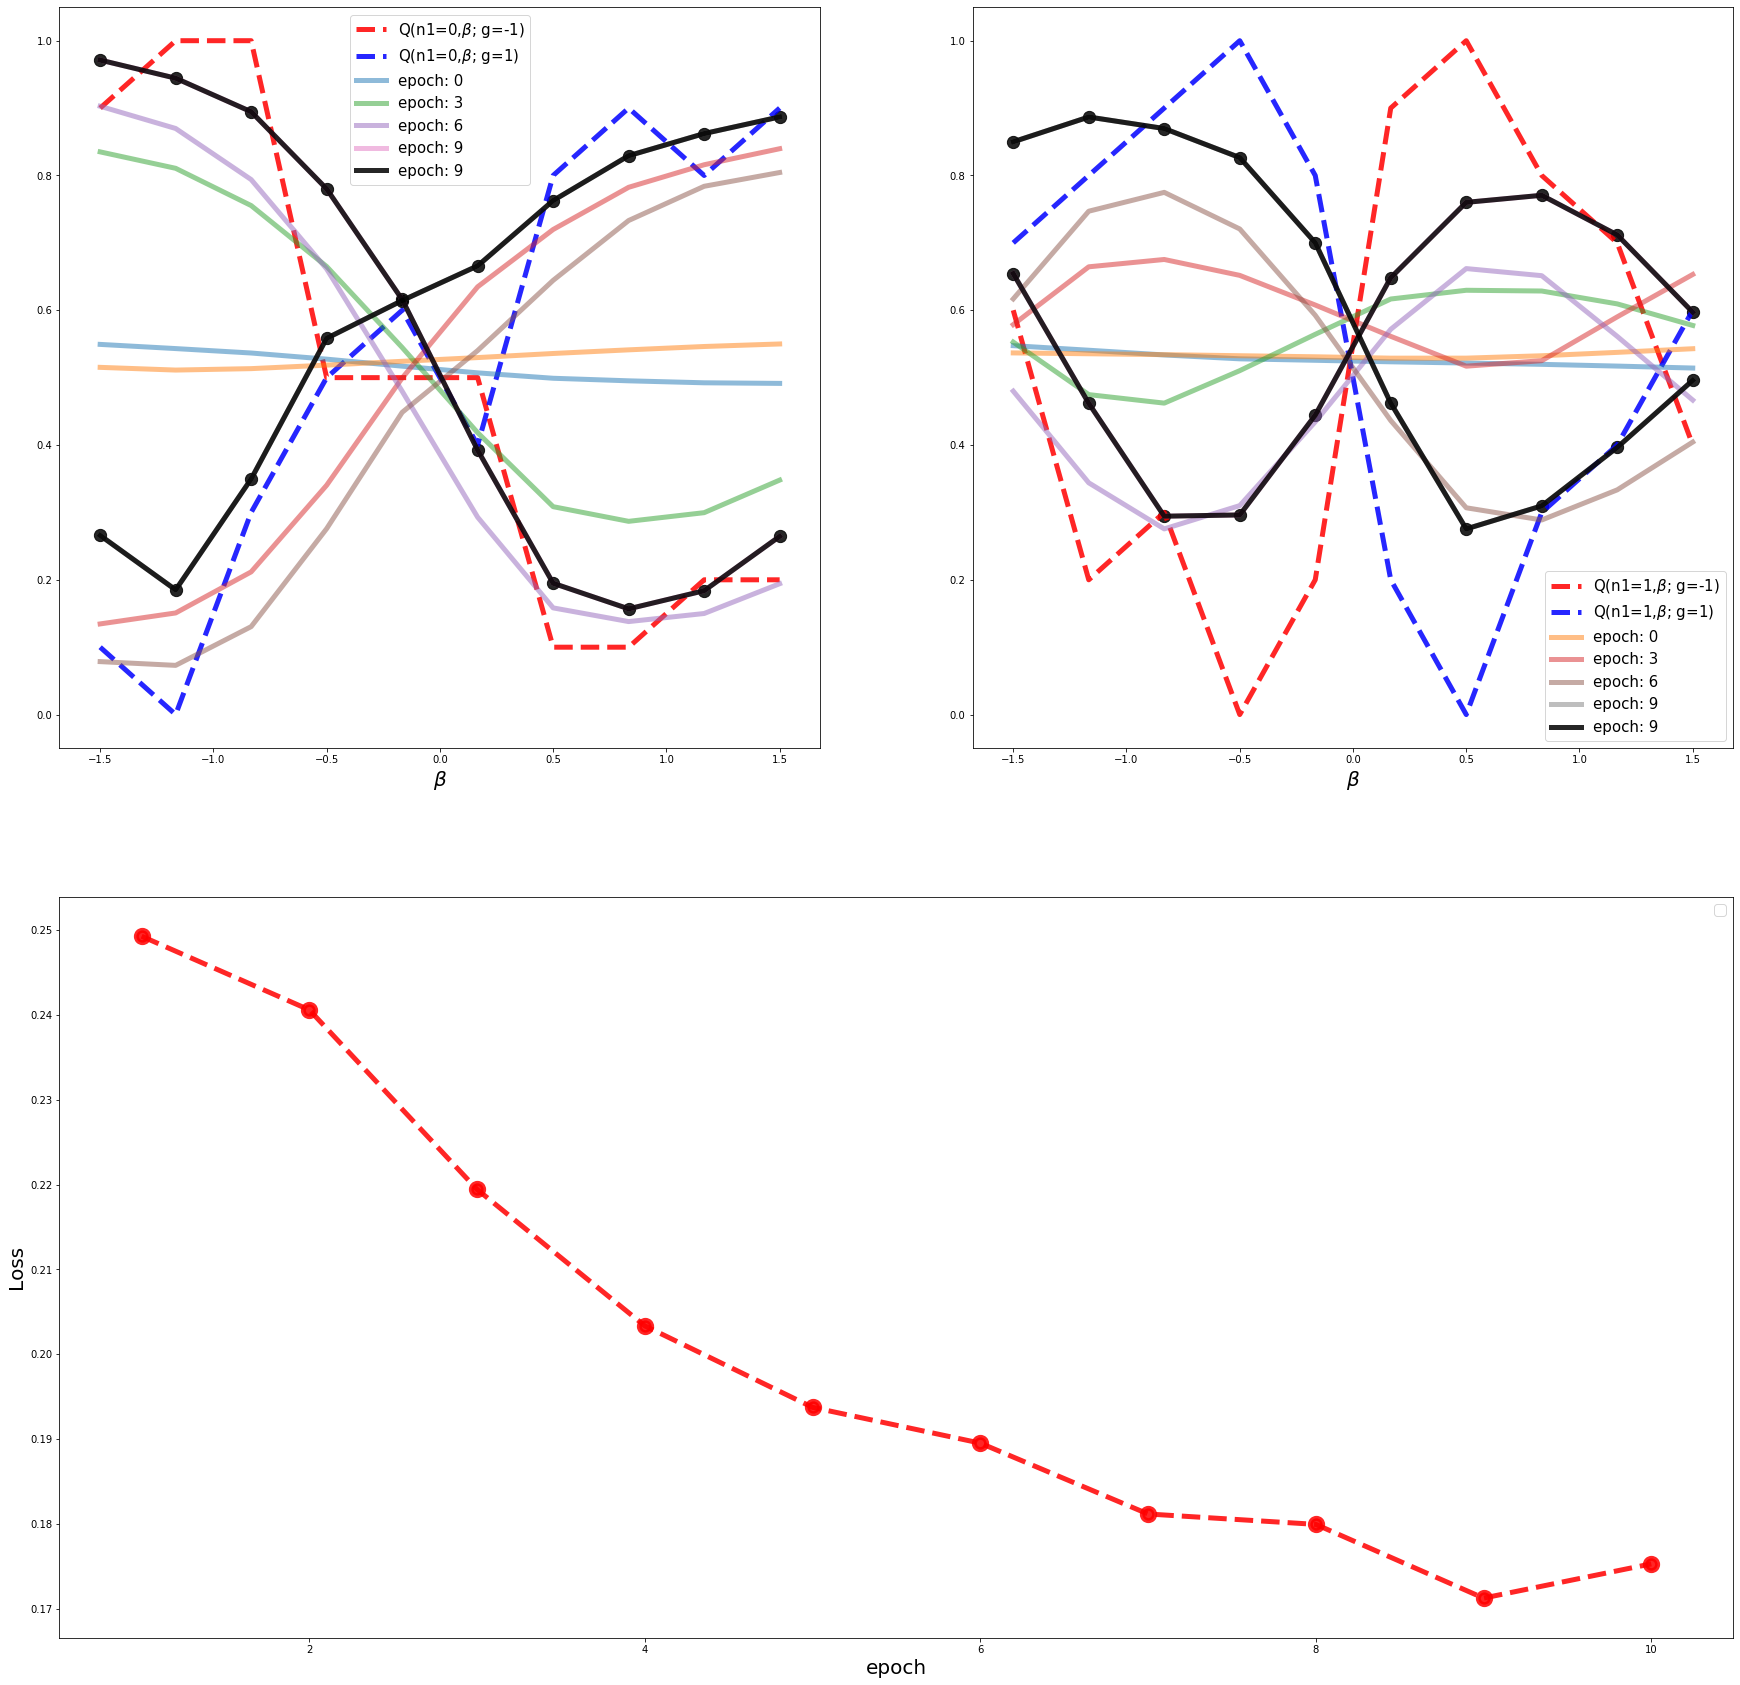

In [14]:
loss_ev, histo_preds, mean_values, differencesb1 = training(splits_over_size=1)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

## Now we test with batch_size of 2. ##

batch_size:  2


W0401 11:43:22.503555 140449948653376 legend.py:1282] No handles with labels found to put in legend.


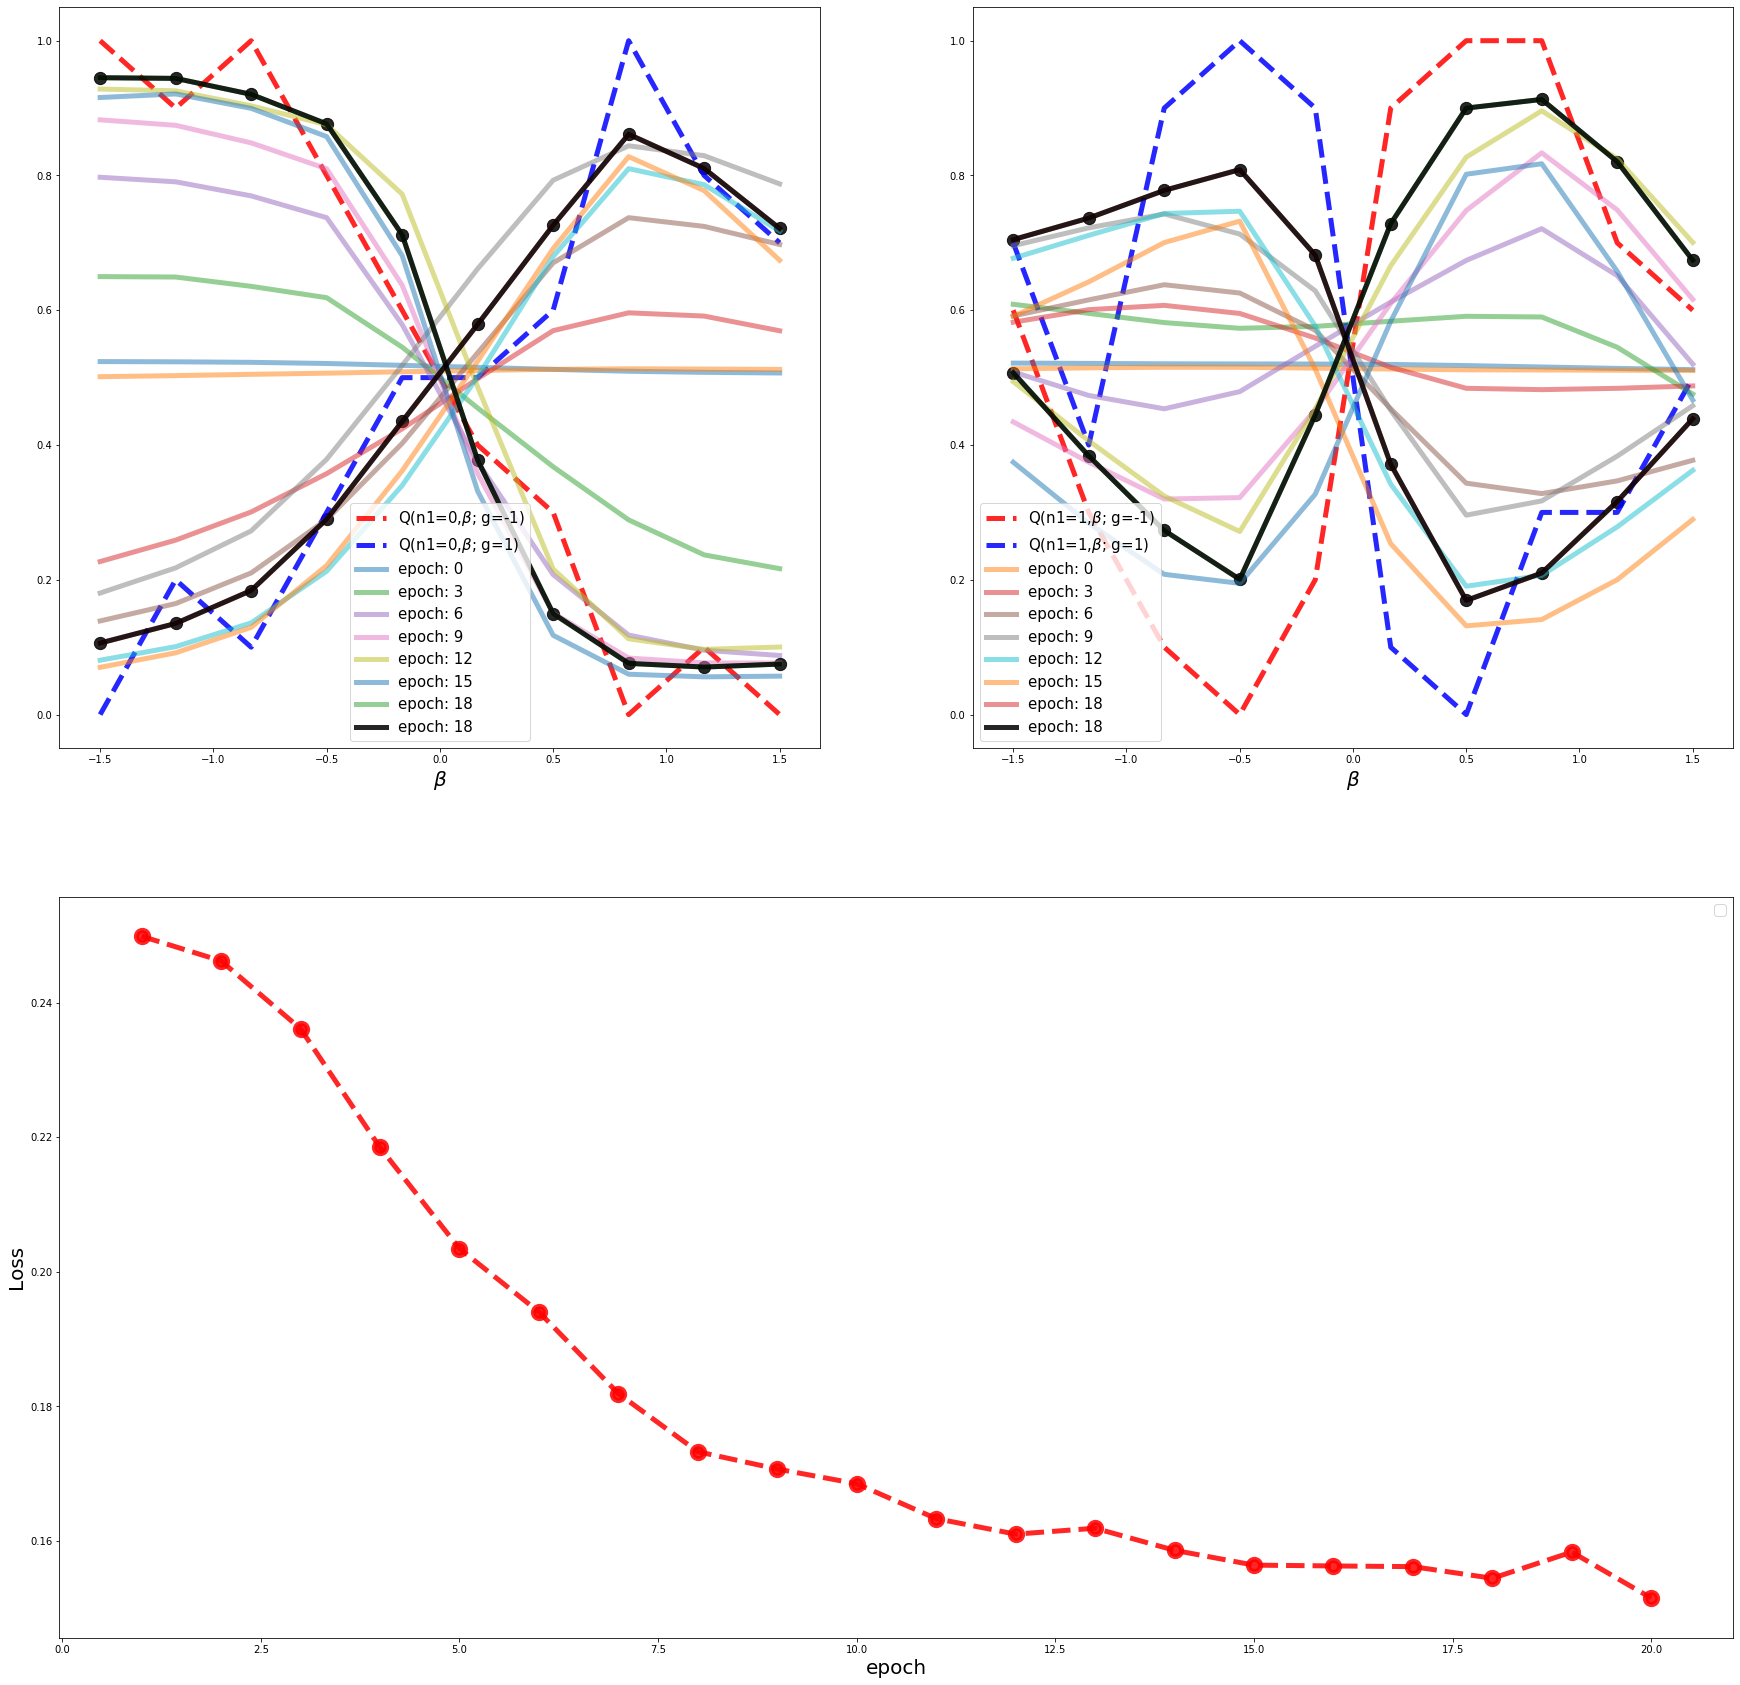

In [16]:
loss_ev, histo_preds, mean_values, differences = training(splits_over_size=2)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

In [ ]:
## Now we test with batch_size of 4. ##

batch_size:  4


W0401 11:43:57.517326 140449948653376 legend.py:1282] No handles with labels found to put in legend.


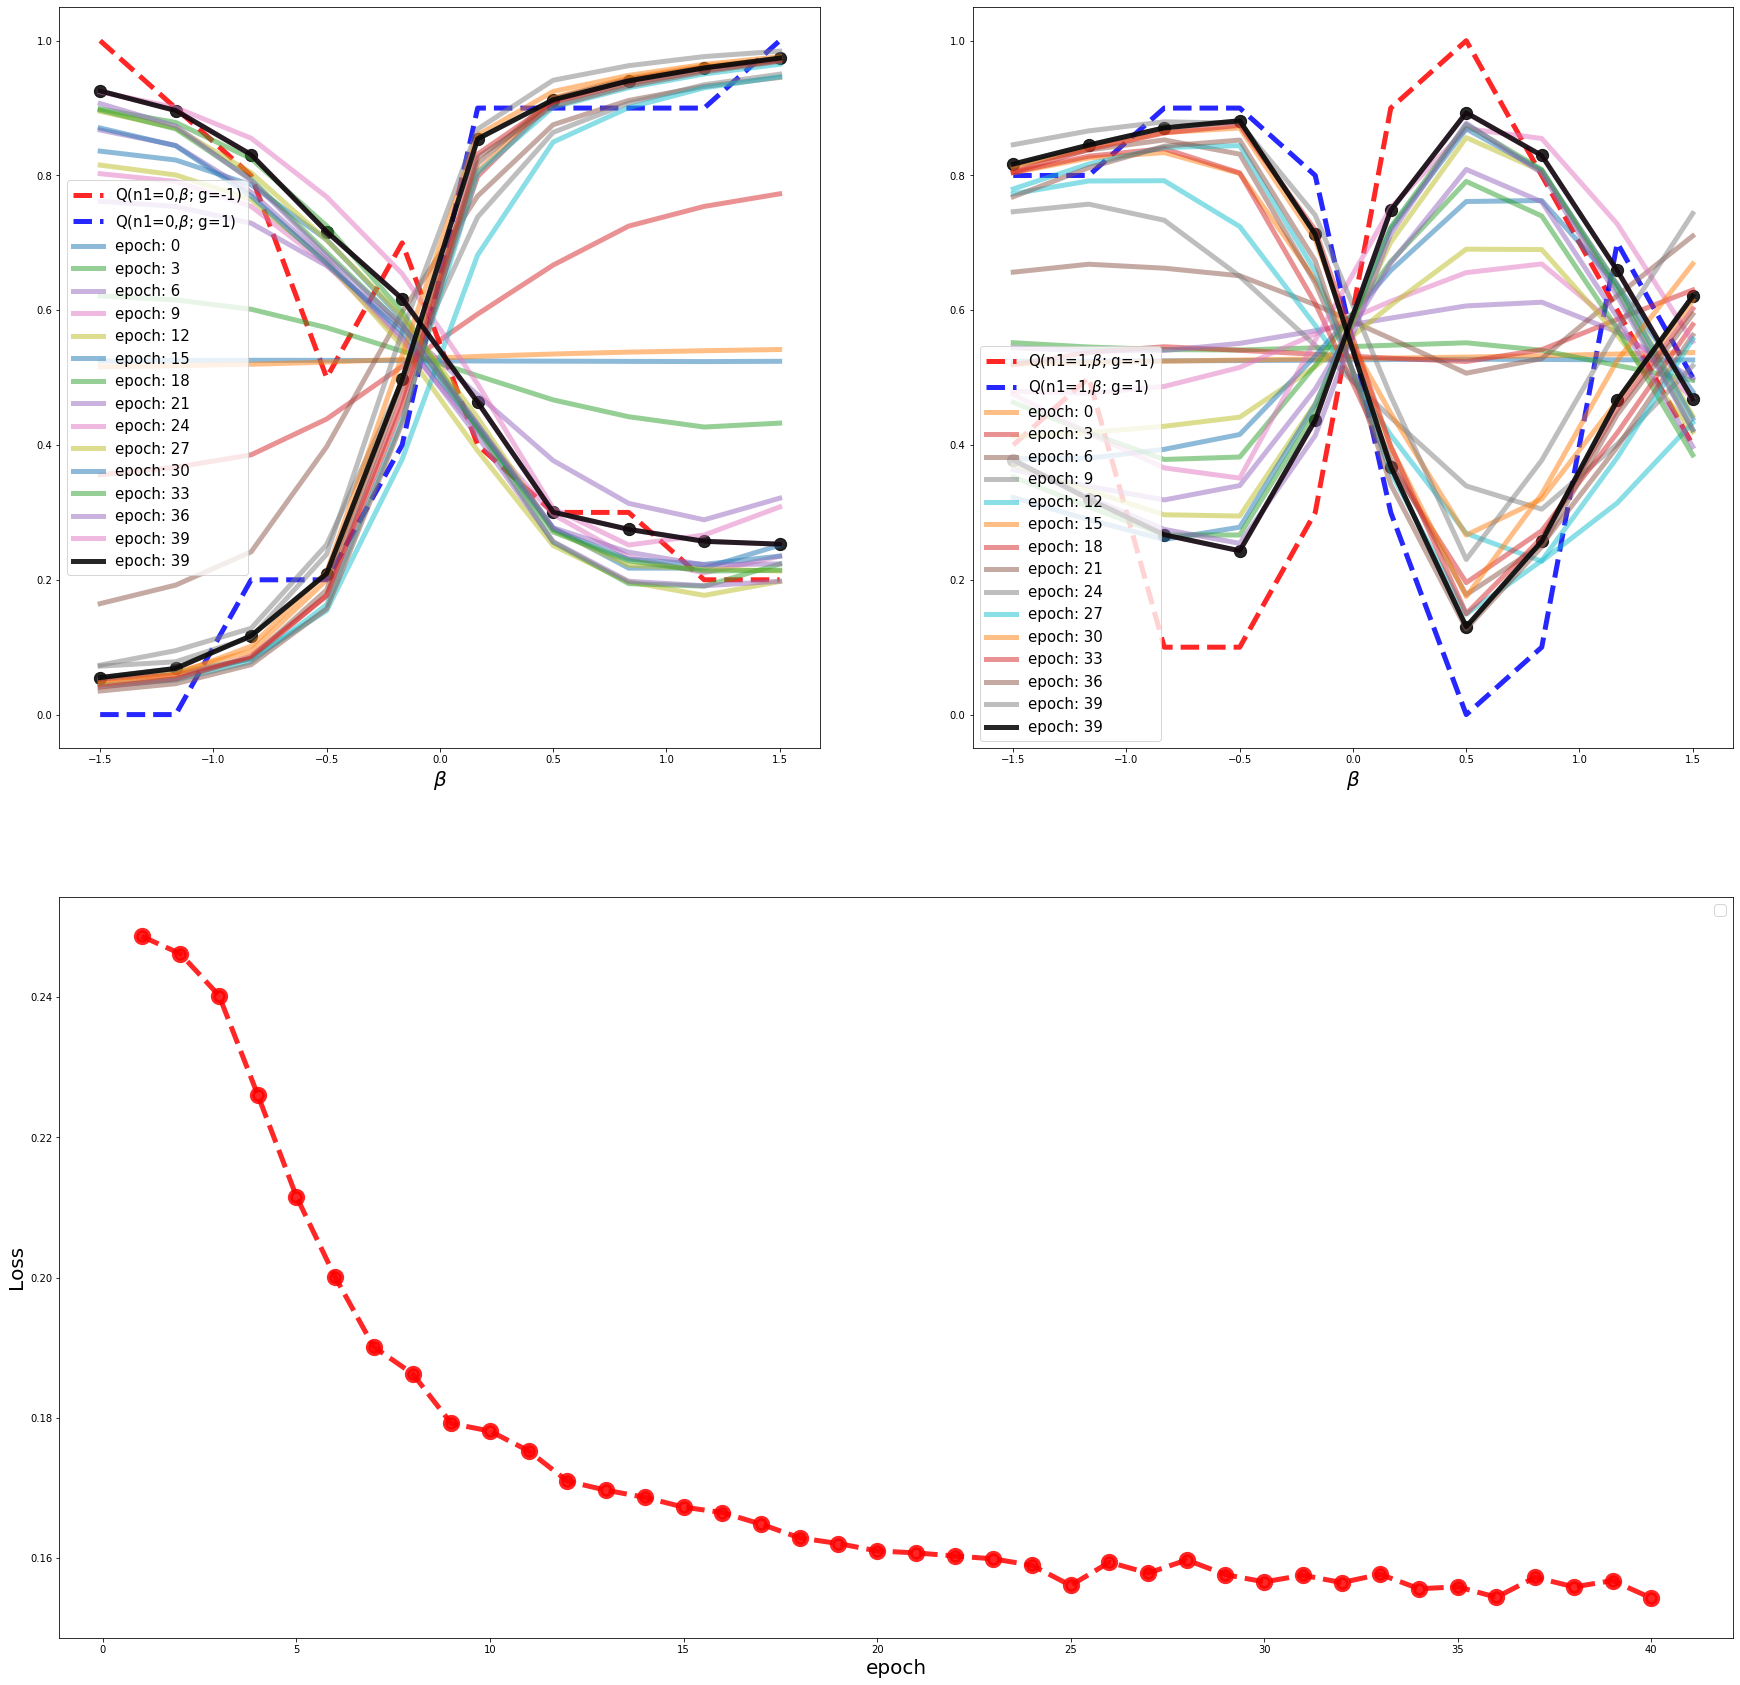

In [17]:
loss_ev, histo_preds, mean_values, differencesb4 = training(splits_over_size=4)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

batch_size:  8


W0401 11:44:43.828614 140449948653376 legend.py:1282] No handles with labels found to put in legend.


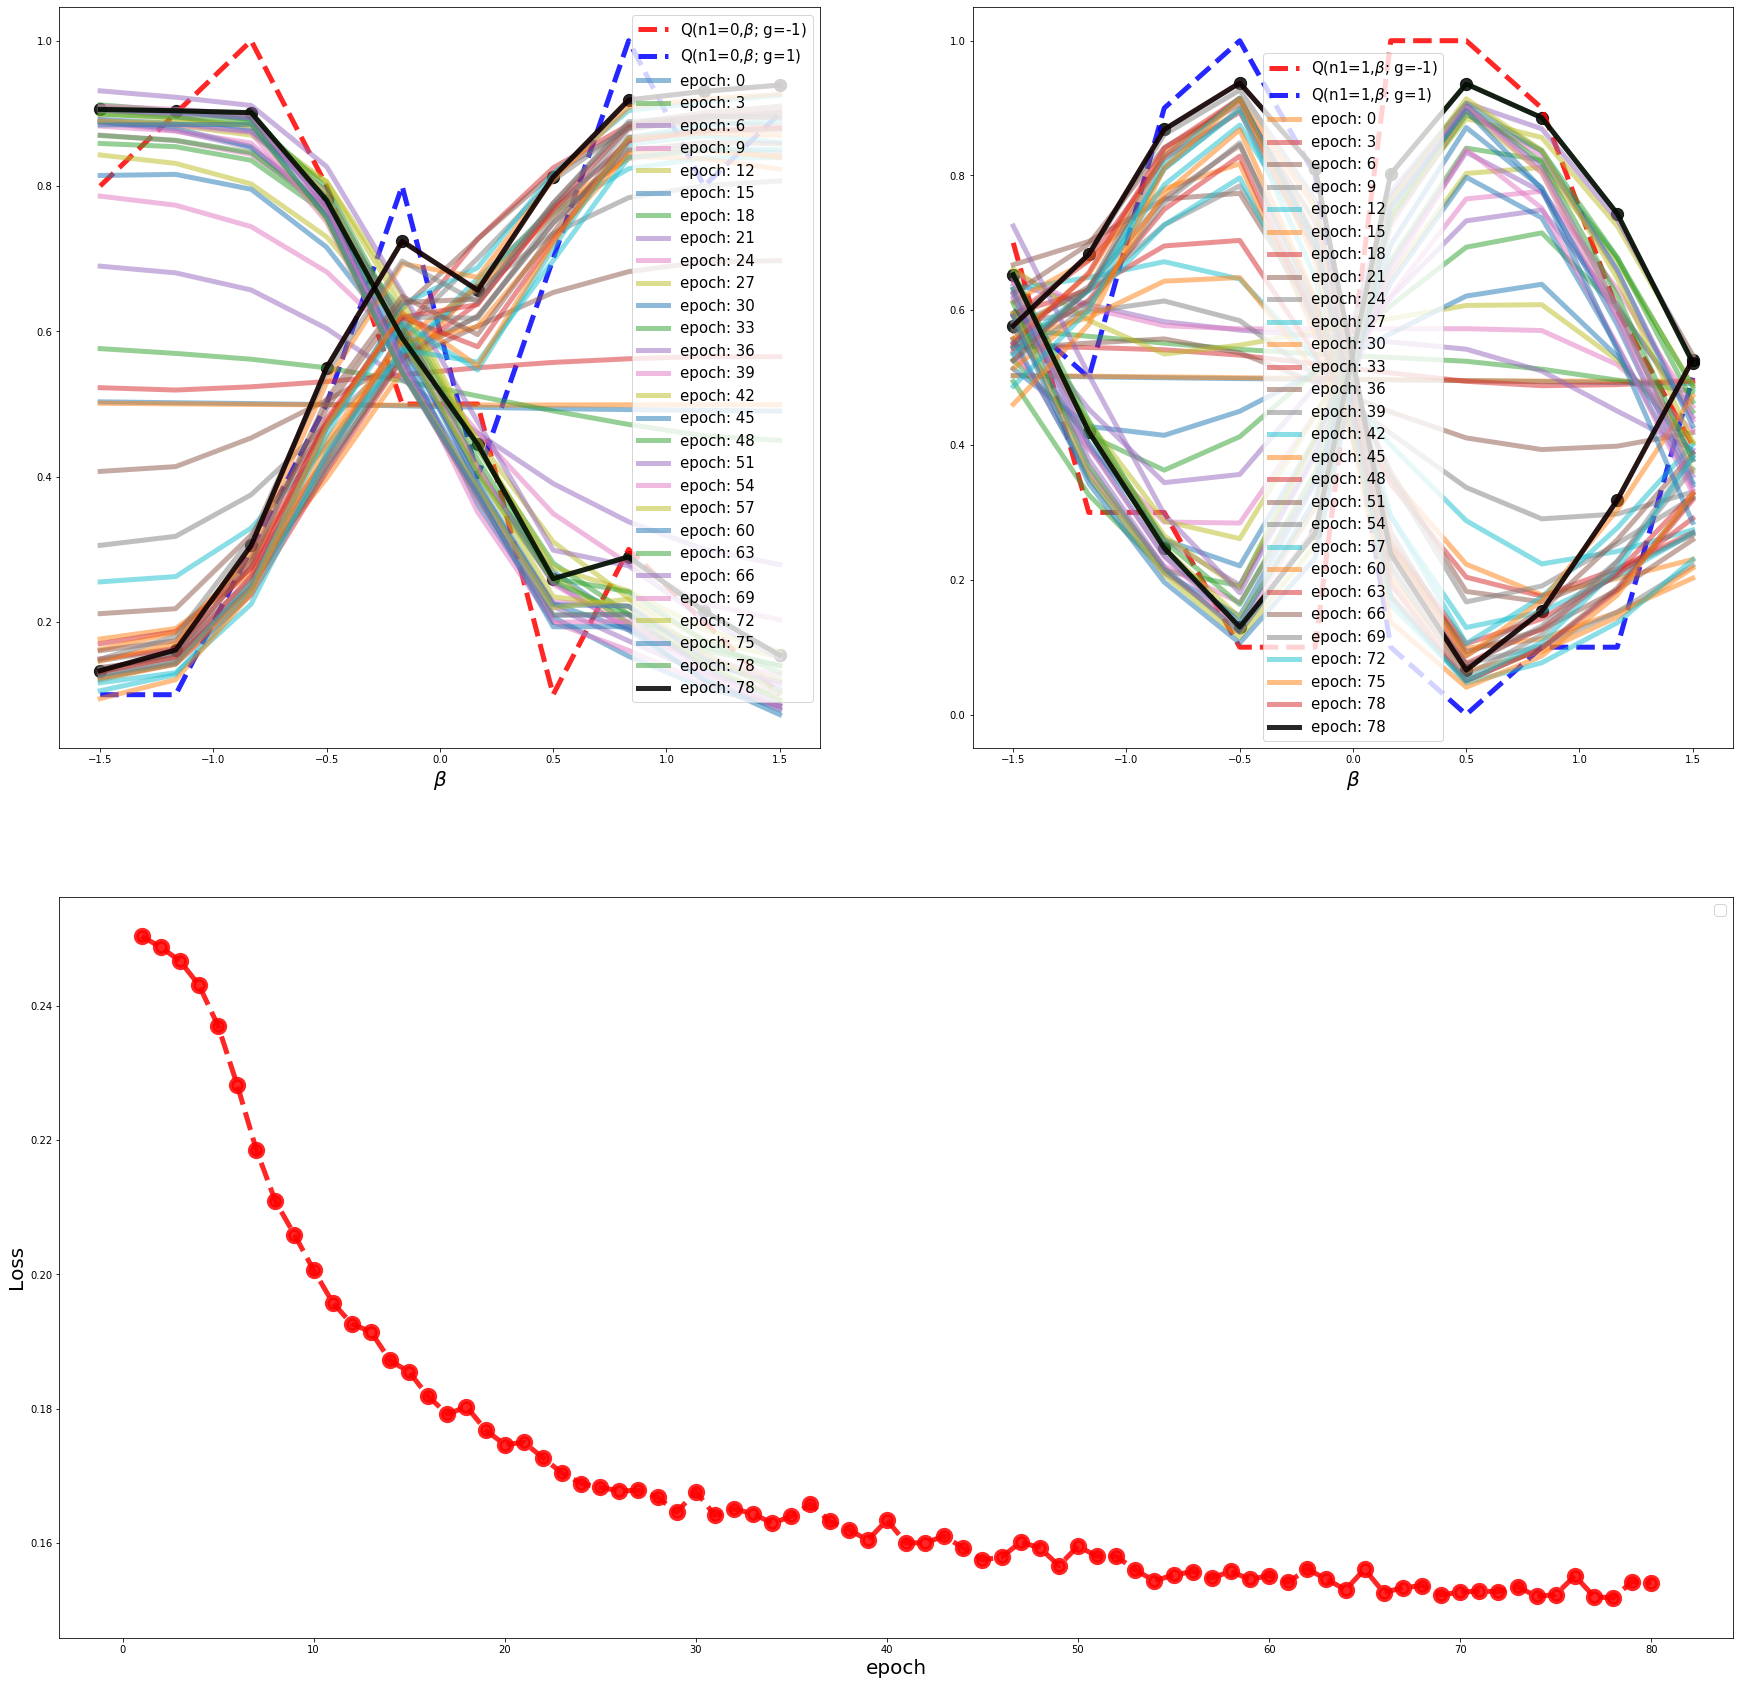

In [18]:
loss_ev, histo_preds, mean_values, differencesb8 = training(splits_over_size=8)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

batch_size:  16


W0401 16:53:41.005218 140449948653376 legend.py:1282] No handles with labels found to put in legend.


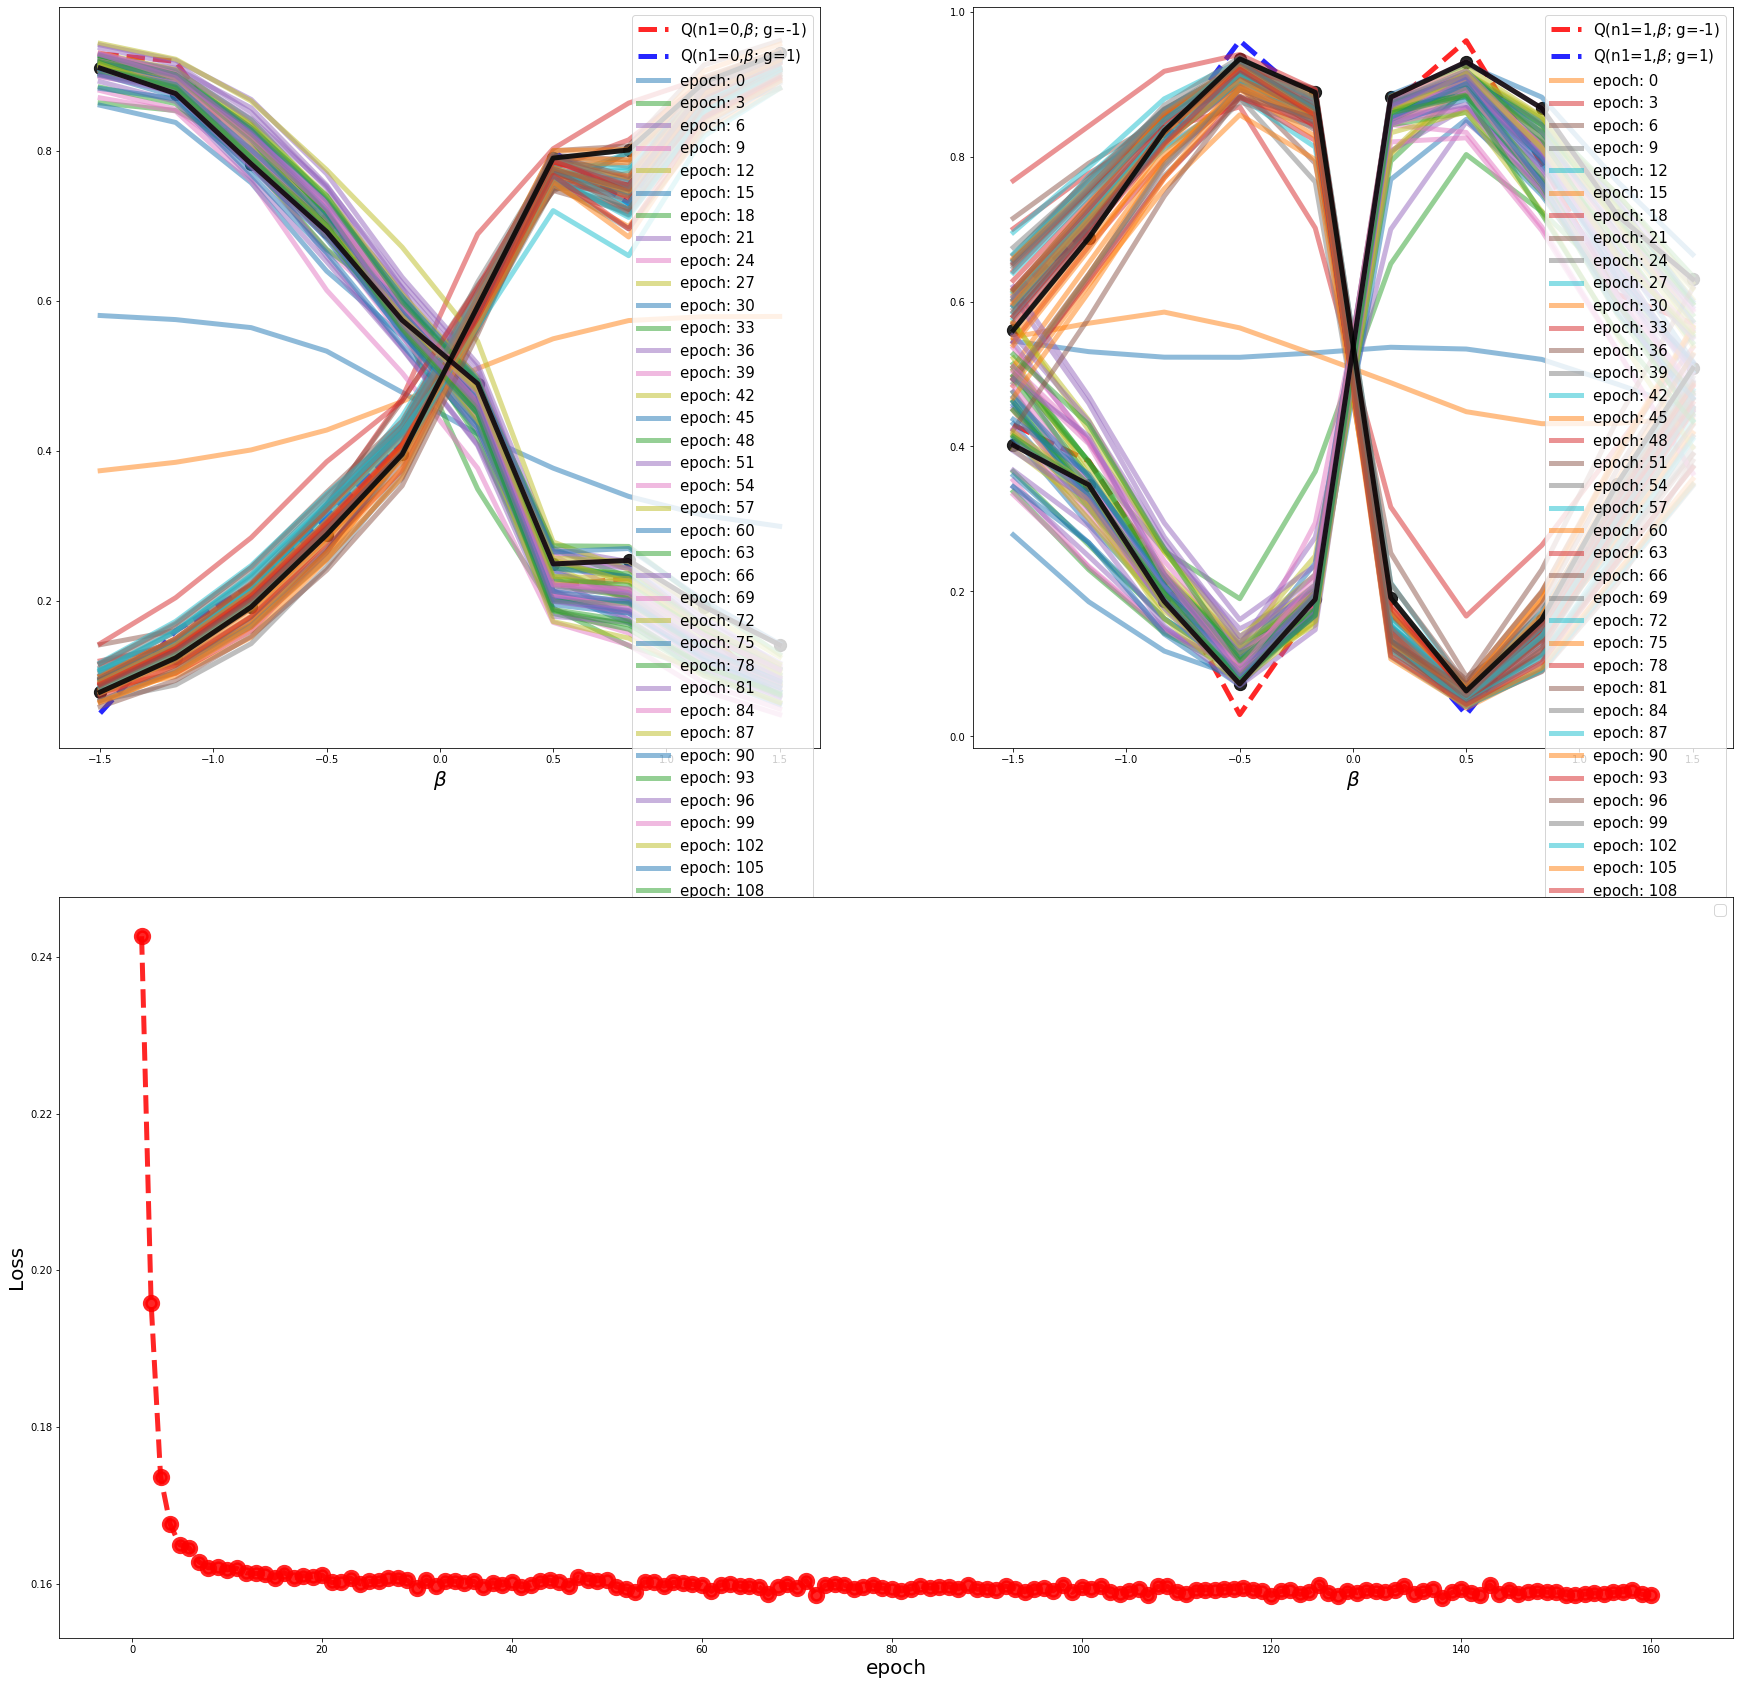

In [28]:
loss_ev, histo_preds, mean_values, differencesb8 = training(splits_over_size=16, rews_per=100)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)